In [27]:
# Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgbm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the dataset from the CSV file
potability = pd.read_csv('water_potability.csv')

# View basic statistics of the dataset to understand its distribution
potability.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [3]:
# Check for missing values in the dataset (each column will show the count of missing values)
potability.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [4]:
# Drop rows with missing values from the dataset
# This will remove any rows that contain NaN values
potability = potability.dropna(axis=0)

# View the updated statistics after handling missing values
potability.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000
mean,7.085990,195.968072,21917.441374,7.134338,333.224672,426.526409,14.357709,66.400859,3.969729,0.403282
std,1.573337,32.635085,8642.239815,1.584820,41.205172,80.712572,3.324959,16.077109,0.780346,0.490678
min,0.227499,73.492234,320.942611,1.390871,129.000000,201.619737,2.200000,8.577013,1.450000,0.000000
25%,6.089723,176.744938,15615.665390,6.138895,307.632511,366.680307,12.124105,55.952664,3.442915,0.000000
50%,7.027297,197.191839,20933.512750,7.143907,332.232177,423.455906,14.322019,66.542198,3.968177,0.000000
75%,8.052969,216.441070,27182.587067,8.109726,359.330555,482.373169,16.683049,77.291925,4.514175,1.000000
max,14.000000,317.338124,56488.672413,13.127000,481.030642,753.342620,27.006707,124.000000,6.494749,1.000000


In [5]:
# Check for missing values in the dataset (each column will show the count of missing values)
potability.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [6]:
# Separate the features (X) from the target variable (y)
# 'Potability' is the target column, and the rest are the features
X = potability.drop("Potability", axis=1)  # Features
y = potability["Potability"]  # Target variable (0 or 1)

# Initialize the StandardScaler to scale the features (mean = 0, standard deviation = 1)
scaler = StandardScaler()

# Scale the features to normalize them; this step helps some models perform better
X_scaled = scaler.fit_transform(X)

In [7]:
# Split the dataset into training and testing sets (80% training, 20% testing)
# This ensures we have a separate set of data to evaluate the model's performance
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [8]:
print(y_train.value_counts())

Potability
0    969
1    639
Name: count, dtype: int64


In [9]:
# Combine X_train and y_train into one dataset for resampling
train_data = pd.concat([pd.DataFrame(X_train), pd.Series(y_train)], axis=1)
train_data = train_data.dropna(axis = 0)

In [10]:
# Separate the majority and minority classes
majority = train_data[train_data.iloc[:, -1] == 0]
minority = train_data[train_data.iloc[:, -1] == 1]

# Oversample the minority class
minority_oversampled = resample(minority,
                                replace=True,  # Sample with replacement
                                n_samples=len(majority),  # Match number of majority class
                                random_state=42)

In [11]:
# Combine the oversampled minority with the majority class
train_data_balanced = pd.concat([majority, minority_oversampled])

# Split the resampled data back into X_train and y_train
X_train_balanced = train_data_balanced.iloc[:, :-1]
y_train_balanced = train_data_balanced.iloc[:, -1]

In [12]:
#Initialize Logistic Regression model
model = LogisticRegression(max_iter = 200)

# Train the Logistic Regression model
model.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test set
y_pred_oversampled = model.predict(X_test)

# Evaluate the model
accuracy_oversampled = accuracy_score(y_test, y_pred_oversampled)
print(f"Oversampled Logistic Regression Accuracy: {accuracy_oversampled * 100:.2f}%")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_oversampled))
print("Classification Report:")
print(classification_report(y_test, y_pred_oversampled))

Oversampled Logistic Regression Accuracy: 50.37%
Confusion Matrix:
[[124 107]
 [ 93  79]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.54      0.55       231
           1       0.42      0.46      0.44       172

    accuracy                           0.50       403
   macro avg       0.50      0.50      0.50       403
weighted avg       0.51      0.50      0.51       403



In [13]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the oversampled training set
rf_model.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 58.81%
Confusion Matrix:
[[204  27]
 [139  33]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.88      0.71       231
           1       0.55      0.19      0.28       172

    accuracy                           0.59       403
   macro avg       0.57      0.54      0.50       403
weighted avg       0.58      0.59      0.53       403



In [14]:
rf_model = RandomForestClassifier(random_state = 42)
# Define the parameter grid
param_grid = {
    'n_estimators': [40],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=1, verbose=1)

# Fit the model
grid_search.fit(X_train_balanced, y_train_balanced)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Use the best estimator to make predictions
best_rf_model = grid_search.best_estimator_
y_pred_rf_tuned = best_rf_model.predict(X_test)

# Evaluate the tuned Random Forest model
accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
print(f"Tuned Random Forest Accuracy: {accuracy_rf_tuned * 100:.2f}%")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_tuned))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_tuned))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best hyperparameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}
Tuned Random Forest Accuracy: 57.32%
Confusion Matrix:
[[201  30]
 [142  30]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.87      0.70       231
           1       0.50      0.17      0.26       172

    accuracy                           0.57       403
   macro avg       0.54      0.52      0.48       403
weighted avg       0.55      0.57      0.51       403



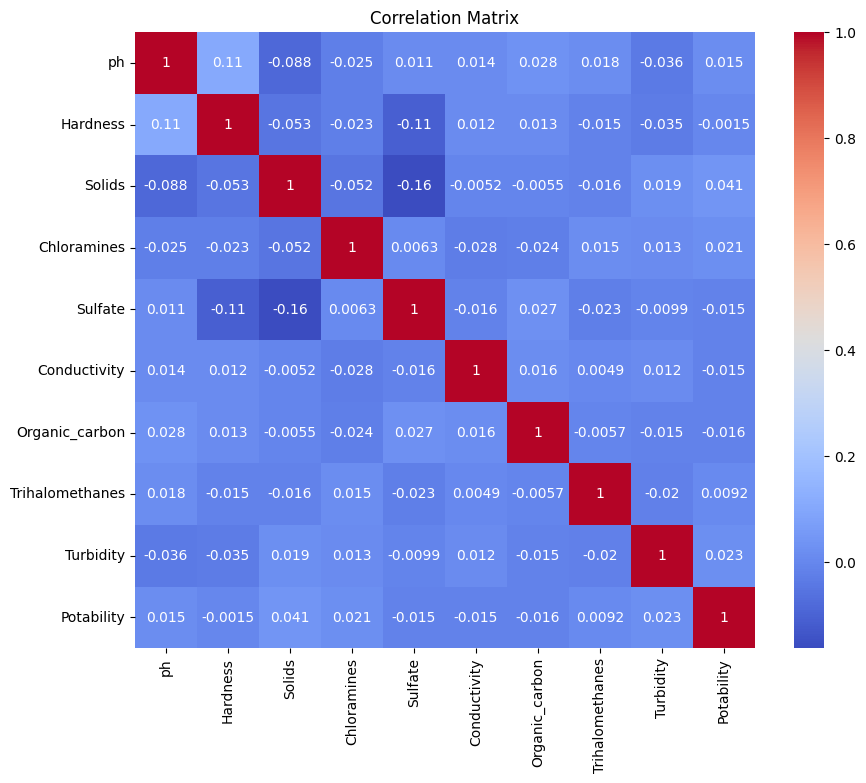

In [15]:
# Create a correlation matrix
corr_matrix = potability.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [16]:
# Generate interaction terms (polynomial features of degree 2)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interaction = poly.fit_transform(X_scaled)

X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_interaction, y, test_size=0.2, random_state=42)

In [17]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the oversampled training set
rf_model.fit(X_train_poly, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_poly)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 68.49%
Confusion Matrix:
[[195  36]
 [ 91  81]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.84      0.75       231
           1       0.69      0.47      0.56       172

    accuracy                           0.68       403
   macro avg       0.69      0.66      0.66       403
weighted avg       0.69      0.68      0.67       403



In [18]:
# Define the parameter grid
param_grid = {
    'n_estimators': [i for i in range(10, 310, 10)],
}

# Initialize the RandomForest model
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_poly, y_train)

print(grid_search.best_params_)
# Check the best parameters
best_rf_model = grid_search.best_estimator_

best_rf_model.fit(X_train_poly, y_train)
y_pred_rf_tuned = best_rf_model.predict(X_test_poly)

# Evaluate the tuned Random Forest model
accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
print(f"Tuned Random Forest Accuracy: {accuracy_rf_tuned * 100:.2f}%")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_tuned))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_tuned))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END ....................................n_estimators=10; total time=   0.1s
[CV] END ....................................n_estimators=10; total time=   0.1s
[CV] END ....................................n_estimators=10; total time=   0.1s
[CV] END ....................................n_estimators=20; total time=   0.1s
[CV] END ....................................n_estimators=20; total time=   0.1s
[CV] END ....................................n_estimators=20; total time=   0.1s
[CV] END ....................................n_estimators=30; total time=   0.2s
[CV] END ....................................n_estimators=30; total time=   0.2s
[CV] END ....................................n_estimators=30; total time=   0.2s
[CV] END ....................................n_estimators=40; total time=   0.2s
[CV] END ....................................n_estimators=40; total time=   0.2s
[CV] END ....................................n_e

/opt/miniconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'n_estimators': 230}
Tuned Random Forest Accuracy: 69.73%
Confusion Matrix:
[[198  33]
 [ 89  83]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.86      0.76       231
           1       0.72      0.48      0.58       172

    accuracy                           0.70       403
   macro avg       0.70      0.67      0.67       403
weighted avg       0.70      0.70      0.68       403



In [19]:
# Function to test different thresholds
def test_thresholds(model, X_test, y_test, thresholds):
    # Get predicted probabilities for class 1 (potable)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    for threshold in thresholds:
        # Apply custom threshold
        y_pred_custom_threshold = (y_pred_prob >= threshold).astype(int)
        
        # Print classification report for each threshold
        print(f"\nClassification Report for Threshold {threshold}:")
        print(classification_report(y_test, y_pred_custom_threshold))

In [20]:
rf = RandomForestClassifier(n_estimators=230, random_state=42)

rf.fit(X_train_poly, y_train)

# Define a range of thresholds to test
thresholds = np.arange(0.3, 0.7, 0.05)  # Test thresholds from 0.3 to 0.65

# Test different thresholds
test_thresholds(rf, X_test_poly, y_test, thresholds)


Classification Report for Threshold 0.3:
              precision    recall  f1-score   support

           0       0.83      0.35      0.49       231
           1       0.51      0.90      0.65       172

    accuracy                           0.59       403
   macro avg       0.67      0.63      0.57       403
weighted avg       0.69      0.59      0.56       403


Classification Report for Threshold 0.35:
              precision    recall  f1-score   support

           0       0.79      0.50      0.61       231
           1       0.55      0.82      0.66       172

    accuracy                           0.64       403
   macro avg       0.67      0.66      0.63       403
weighted avg       0.69      0.64      0.63       403


Classification Report for Threshold 0.39999999999999997:
              precision    recall  f1-score   support

           0       0.74      0.63      0.68       231
           1       0.59      0.70      0.64       172

    accuracy                           

In [21]:
# Initialize the Random Forest model
rf = RandomForestClassifier(n_estimators=230, random_state=42)

# Initialize RFE with the Random Forest model
rfe = RFE(estimator=rf, n_features_to_select=20)  # Adjust n_features_to_select as needed

# Fit RFE
rfe.fit(X_train_poly, y_train)

# Check which features were selected
selected_features = rfe.support_

# Filter the polynomial features to only include selected ones
X_train_poly_selected = X_train_poly[:, selected_features]
X_test_poly_selected = X_test_poly[:, selected_features]

# Train Random Forest again with the selected features
rf_selected = RandomForestClassifier(n_estimators=230, random_state=42)
rf_selected.fit(X_train_poly_selected, y_train)

# Get predicted probabilities for the selected features
y_pred_prob_selected = rf_selected.predict_proba(X_test_poly_selected)[:, 1]

# Apply the custom threshold (e.g., 0.4)
threshold = 0.4
y_pred_custom_threshold = (y_pred_prob_selected >= threshold).astype(int)

# Evaluate the model with the custom threshold
print(f"Classification Report with Threshold {threshold}:")
print(classification_report(y_test, y_pred_custom_threshold))

Classification Report with Threshold 0.4:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69       231
           1       0.59      0.72      0.65       172

    accuracy                           0.67       403
   macro avg       0.67      0.68      0.67       403
weighted avg       0.68      0.67      0.67       403



In [29]:
# Define the base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=230, random_state=42)),
    ('lr', LogisticRegression(max_iter=1000)),
    ('lgbm', lgbm.LGBMClassifier(n_estimators=100, random_state=42))
]

# Use Gradient Boosting as the meta-model
meta_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Define the stacking classifier
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train the stacked model
stacked_model.fit(X_train_poly_selected, y_train)

# Get predicted probabilities and apply the custom threshold (0.4)
y_pred_prob_stack = stacked_model.predict_proba(X_test_poly_selected)[:, 1]
threshold = 0.4
y_pred_custom_threshold_stack = (y_pred_prob_stack >= threshold).astype(int)

# Evaluate the stacked model
print(f"Stacked Model with LightGBM and Gradient Boosting as Meta-Model (Threshold {threshold}):")
print(classification_report(y_test, y_pred_custom_threshold_stack))

[LightGBM] [Info] Number of positive: 639, number of negative: 969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1608, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.397388 -> initscore=-0.416360
[LightGBM] [Info] Start training from score -0.416360
[LightGBM] [Info] Number of positive: 511, number of negative: 775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1286, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.397356 -> initscore=-0.416493
[LightGBM] [Info] Start training from score -0.416493
[LightGBM] [Info] Numb